In [ ]:
# 1. INSTALL YOLOv8 
!pip install -q ultralytics --no-deps

In [ ]:
# 2. IMPORT LIBRARIES 
import os, random, collections
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import cv2

from ultralytics import YOLO
from ultralytics.data.converter import convert_coco

import kagglehub


In [ ]:
# 3. DOWNLOAD the kneroma/tacotrashdataset 
# fetching & unpacking the dataset to a local folder
dataset_path = kagglehub.dataset_download("kneroma/tacotrashdataset")
print("✅ Dataset unpacked at:", dataset_path)

# Peek at its structure
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    if level >= 1:
        print(f"{indent}  files:", files[:5], "…")
    if level >= 2:
        break


✅ Dataset unpacked at: /kaggle/input/tacotrashdataset
tacotrashdataset/
  data/
    files: ['annotations.json'] …
    batch_4/
      files: ['000050.JPG', '000081.JPG', '000040.JPG', '000021.JPG', '000015.JPG'] …


In [10]:
from pathlib import Path

inp = Path("/kaggle/input/tacotrashdataset/data")
txts = list(inp.rglob("*.txt"))
print(f"Found {len(txts)} .txt files in:\n", {p.parent for p in txts})


Found 0 .txt files in:
 set()


In [ ]:
# A) INSPECT JSON
import json
coco_json = "/kaggle/input/tacotrashdataset/data/annotations.json"
with open(coco_json) as f:
    coco = json.load(f)

# Showing the first few image records:
for img in coco["images"][:5]:
    print(img)


{'id': 0, 'width': 1537, 'height': 2049, 'file_name': 'batch_1/000006.jpg', 'license': None, 'flickr_url': 'https://farm66.staticflickr.com/65535/33978196618_e30a59e0a8_o.png', 'coco_url': None, 'date_captured': None, 'flickr_640_url': 'https://farm66.staticflickr.com/65535/33978196618_632623b4fc_z.jpg'}
{'id': 1, 'width': 1537, 'height': 2049, 'file_name': 'batch_1/000008.jpg', 'license': None, 'flickr_url': 'https://farm66.staticflickr.com/65535/47803331152_ee00755a2e_o.png', 'coco_url': None, 'date_captured': None, 'flickr_640_url': 'https://farm66.staticflickr.com/65535/47803331152_19beae025a_z.jpg'}
{'id': 2, 'width': 1537, 'height': 2049, 'file_name': 'batch_1/000010.jpg', 'license': None, 'flickr_url': 'https://farm66.staticflickr.com/65535/40888872753_08ffb24902_o.png', 'coco_url': None, 'date_captured': None, 'flickr_640_url': 'https://farm66.staticflickr.com/65535/40888872753_631ab0f441_z.jpg'}
{'id': 3, 'width': 2049, 'height': 1537, 'file_name': 'batch_1/000019.jpg', 'licen

In [ ]:
# MANUAL COCO to YOLO TXT (UPDATED for batch_1…batch_4)
import json, os, random, shutil
from pathlib import Path

# 1) Paths
coco_json = "/kaggle/input/tacotrashdataset/data/annotations.json"
imgs_root = "/kaggle/input/tacotrashdataset/data"   # root for batch_1/, batch_2/, etc.
out_root  = "taco_yolo_manual"

# 2) Load COCO
with open(coco_json) as f:
    coco = json.load(f)
images = {img["id"]: img for img in coco["images"]}
anns   = coco["annotations"]

# 3) Group annotations by image_id
anns_per_image = {}
for a in anns:
    anns_per_image.setdefault(a["image_id"], []).append(a)

# 4) Make output YOLO folders
for split in ("train", "val"):
    (Path(out_root)/"images"/split).mkdir(parents=True, exist_ok=True)
    (Path(out_root)/"labels"/split).mkdir(parents=True, exist_ok=True)

# 5) 80/20 random split of image IDs
img_ids  = list(images.keys())
random.shuffle(img_ids)
split_idx = int(0.8 * len(img_ids))
splits = {"train": img_ids[:split_idx], "val": img_ids[split_idx:]}

# 6) Copying images & writing labels
for split, ids in splits.items():
    for img_id in ids:
        img = images[img_id]
        fn  = img["file_name"]      # e.g. "batch_1/000000000001.jpg"
        w, h = img["width"], img["height"]

        # Copying image from imgs_root/<fn> → out_root/images/<split>/
        src = Path(imgs_root) / fn
        dst = Path(out_root)/"images"/split/Path(fn).name
        shutil.copy(src, dst)

        # Write YOLO txt label
        lbl_path = Path(out_root)/"labels"/split/(Path(fn).stem + ".txt")
        with open(lbl_path, "w") as f:
            for a in anns_per_image.get(img_id, []):
                cid = a["category_id"]
                x, y, bw, bh = a["bbox"]
                # Convert to YOLO center x,y,w,h normalized
                xc = (x + bw/2) / w
                yc = (y + bh/2) / h
                f.write(f"{cid} {xc:.6f} {yc:.6f} {bw/w:.6f} {bh/h:.6f}\n")

print("✅ Manual conversion complete →", out_root)


✅ Manual conversion complete → taco_yolo_manual


In [ ]:
# VERIFYING THE OUTPUT 
import os
for root, dirs, files in os.walk("taco_yolo_manual"):
    indent = "  " * (root.count(os.sep) - 1)
    print(f"{indent}{os.path.basename(root)}/ ({len(files)} files)")
# Print one sample label
sample = os.listdir("taco_yolo_manual/labels/train")[0]
print("\nSample label taco_yolo_manual/labels/train/" + sample + ":\n",
      open("taco_yolo_manual/labels/train/" + sample).read().strip())


taco_yolo_manual/ (0 files)
labels/ (0 files)
  train/ (213 files)
  val/ (128 files)
images/ (0 files)
  train/ (312 files)
  val/ (181 files)

Sample label taco_yolo_manual/labels/train/IMG_4855.txt:
 14 0.434896 0.473448 0.106924 0.165850


In [ ]:
# 7. BUILDING data.yaml 
import json
from pathlib import Path

# 1) Loading class names from COCO JSON
coco_json = "/kaggle/input/tacotrashdataset/data/annotations.json"
with open(coco_json) as f:
    cats = json.load(f)["categories"]
# Building id→name map
names = {c["id"]: c["name"] for c in cats}

# 2) Paths for YOLO
root = "taco_yolo_manual"
train_images = f"{root}/images/train"
val_images   = f"{root}/images/val"

# 3) Writing YAML
yaml_text = f"""
path: {root}
train: images/train
val:   images/val

names:
"""
for cid in sorted(names):
    yaml_text += f"  {cid}: {names[cid]}\n"

with open("data.yaml","w") as f:
    f.write(yaml_text)

print("✅ data.yaml created:\n", yaml_text)


✅ data.yaml created:
 
path: taco_yolo_manual
train: images/train
val:   images/val

names:
  0: Aluminium foil
  1: Battery
  2: Aluminium blister pack
  3: Carded blister pack
  4: Other plastic bottle
  5: Clear plastic bottle
  6: Glass bottle
  7: Plastic bottle cap
  8: Metal bottle cap
  9: Broken glass
  10: Food Can
  11: Aerosol
  12: Drink can
  13: Toilet tube
  14: Other carton
  15: Egg carton
  16: Drink carton
  17: Corrugated carton
  18: Meal carton
  19: Pizza box
  20: Paper cup
  21: Disposable plastic cup
  22: Foam cup
  23: Glass cup
  24: Other plastic cup
  25: Food waste
  26: Glass jar
  27: Plastic lid
  28: Metal lid
  29: Other plastic
  30: Magazine paper
  31: Tissues
  32: Wrapping paper
  33: Normal paper
  34: Paper bag
  35: Plastified paper bag
  36: Plastic film
  37: Six pack rings
  38: Garbage bag
  39: Other plastic wrapper
  40: Single-use carrier bag
  41: Polypropylene bag
  42: Crisp packet
  43: Spread tub
  44: Tupperware
  45: Disposabl

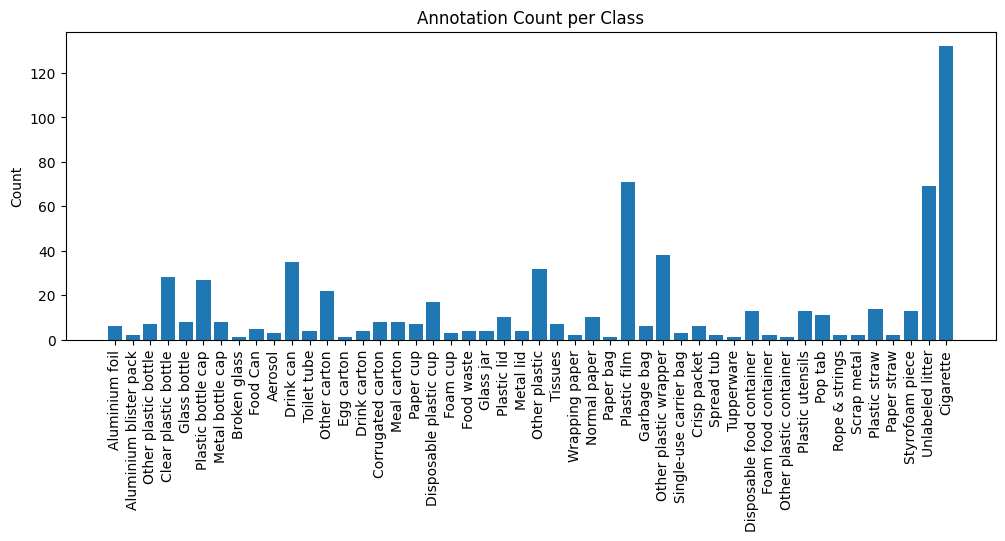

In [ ]:
# 8. DATA VISUALIZATION
import collections, random, cv2
import matplotlib.pyplot as plt
from pathlib import Path

# a) Class frequency bar chart
lbl_dir = Path("taco_yolo_manual/labels/train")
counts = collections.Counter()
for f in lbl_dir.glob("*.txt"):
    for line in open(f):
        counts[int(line.split()[0])] += 1

cls_ids = sorted(counts)
cls_names = [names[i] for i in cls_ids]
freqs = [counts[i] for i in cls_ids]

plt.figure(figsize=(12,4))
plt.bar(cls_names, freqs)
plt.xticks(rotation=90)
plt.title("Annotation Count per Class")
plt.ylabel("Count")
plt.show()


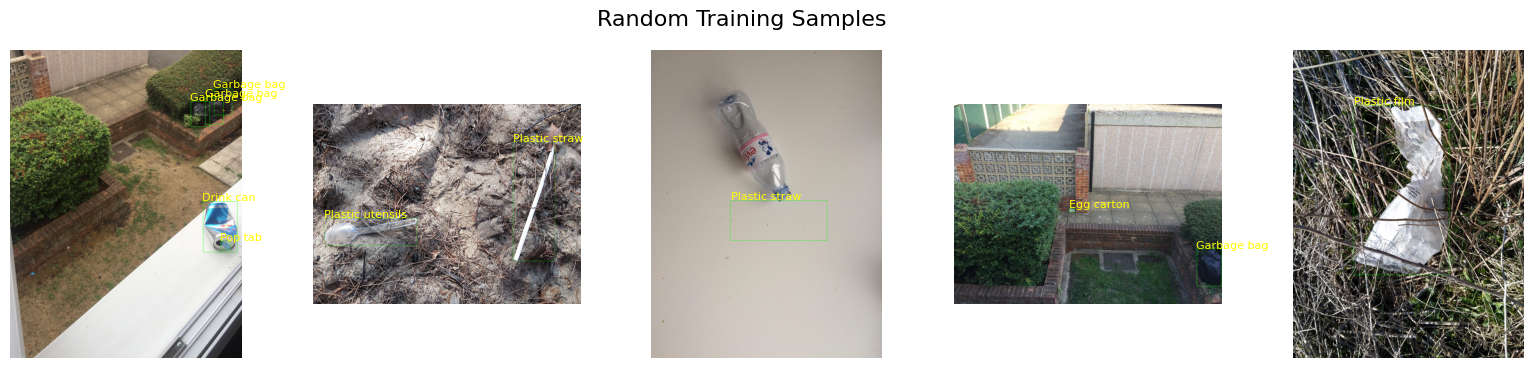

In [ ]:
# b) Show 5 random annotated samples
import random, cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Pick 5 images
img_dir = Path("taco_yolo_manual/images/train")
samples = random.sample(list(img_dir.glob("*.*")), 5)

fig, axes = plt.subplots(1, 5, figsize=(20,4))
for ax, img_path in zip(axes, samples):
    # Read & convert to RGB, then make a writeable copy
    img = cv2.imread(str(img_path))[:,:,::-1].copy()
    h, w = img.shape[:2]

    # Corresponding YOLO label file
    lbl_path = Path("taco_yolo_manual/labels/train")/(img_path.stem + ".txt")
    if lbl_path.exists():
        for line in open(lbl_path):
            cid, x, y, bw, bh = map(float, line.split())
            x1, y1 = int((x - bw/2) * w), int((y - bh/2) * h)
            x2, y2 = int((x + bw/2) * w), int((y + bh/2) * h)
            # Now drawing works because img is writeable
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            ax.text(x1, y1 - 5, names[int(cid)], color="yellow", fontsize=8)

    ax.imshow(img)
    ax.axis("off")

plt.suptitle("Random Training Samples", fontsize=16)
plt.show()


In [ ]:
# 9. MODEL ARCHITECTURE
from ultralytics import YOLO

model = YOLO("yolov8s.pt")  
model.info()              


100%|██████████| 21.5M/21.5M [00:00<00:00, 306MB/s]


YOLOv8s summary: 129 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs


(129, 11166560, 0, 28.816844800000002)

In [ ]:
# 10. TRAIN THE MODEL
results = model.train(
    data="data.yaml",
    epochs=50,       
    imgsz=640,
    batch=16,
    name="waste_detector",
    device=0        
)


Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=waste_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profil

100%|██████████| 755k/755k [00:00<00:00, 36.3MB/s]


Overriding model.yaml nc=80 with nc=60

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 197MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3009.3±1911.8 MB/s, size: 1677.9 KB)


train: Scanning /kaggle/working/taco_yolo_manual/labels/train... 312 images, 0 backgrounds, 0 corrupt: 100%|██████████| 312/312 [00:00<00:00, 1154.29it/s]

train: New cache created: /kaggle/working/taco_yolo_manual/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2057.0±2095.9 MB/s, size: 1481.5 KB)


val: Scanning /kaggle/working/taco_yolo_manual/labels/val... 181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 571.54it/s]

val: New cache created: /kaggle/working/taco_yolo_manual/labels/val.cache


Plotting labels to runs/detect/waste_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000156, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/waste_detector
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.78G      1.571      7.233      1.529         41        640: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


                   all        181        481      0.113      0.013    0.00282    0.00232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.94G      1.554      6.016       1.52         63        640: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


                   all        181        481    0.00458     0.0263    0.00384    0.00344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.98G       1.43      5.042      1.426         38        640: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


                   all        181        481      0.251     0.0323     0.0106    0.00863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.02G      1.323      4.312       1.35         54        640: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


                   all        181        481       0.27     0.0654     0.0169     0.0141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.05G        1.4      4.067      1.374         20        640: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


                   all        181        481      0.396     0.0592     0.0273     0.0215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.09G      1.416      3.715      1.392         26        640: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


                   all        181        481      0.323      0.095     0.0349     0.0294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.12G      1.393      3.558      1.381         51        640: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


                   all        181        481      0.416     0.0892     0.0472      0.041

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.16G      1.324      3.237      1.349         39        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


                   all        181        481      0.467     0.0961     0.0551     0.0464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       5.2G       1.33       3.28      1.337         50        640: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        181        481      0.419      0.107     0.0517     0.0419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.23G      1.337      2.967      1.311         62        640: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


                   all        181        481      0.344     0.0651     0.0378     0.0308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.27G      1.333      2.857      1.315         52        640: 100%|██████████| 20/20 [00:08<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


                   all        181        481      0.345     0.0504     0.0381     0.0316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.31G        1.3      2.754      1.293         39        640: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


                   all        181        481      0.431     0.0667     0.0526      0.044

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.34G      1.301      2.707      1.334         37        640: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


                   all        181        481      0.557      0.052      0.065     0.0543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.38G      1.138       2.39      1.223         36        640: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


                   all        181        481      0.515     0.0564     0.0525     0.0445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.41G      1.197      2.338      1.241         53        640: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


                   all        181        481      0.295     0.0576     0.0437     0.0361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.45G      1.171      2.258       1.22         33        640: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        181        481       0.33     0.0587     0.0458     0.0376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.49G       1.14      2.157       1.23         37        640: 100%|██████████| 20/20 [00:08<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


                   all        181        481       0.29       0.05     0.0386     0.0324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.52G      1.206       2.18      1.248         56        640: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


                   all        181        481       0.34     0.0498      0.039     0.0331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.56G      1.174      2.064      1.218         43        640: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        181        481      0.261      0.079     0.0355     0.0285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       5.6G      1.113      1.975      1.214         54        640: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


                   all        181        481       0.32     0.0757     0.0448     0.0369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.63G      1.187      1.991       1.24         40        640: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


                   all        181        481      0.334     0.0607     0.0681     0.0553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.67G      1.144      1.888      1.234         34        640: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


                   all        181        481      0.349     0.0545     0.0503     0.0402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.71G      1.093      1.835      1.186         54        640: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


                   all        181        481      0.338     0.0536     0.0512     0.0404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.74G      1.135      1.808      1.193         53        640: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

                   all        181        481       0.31     0.0552     0.0465     0.0393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.78G      1.047       1.73      1.191         46        640: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


                   all        181        481      0.315      0.069     0.0586     0.0504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.81G      1.108      1.699       1.19         48        640: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


                   all        181        481      0.383     0.0797     0.0545      0.046

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.85G      1.137      1.762      1.202         61        640: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


                   all        181        481      0.336     0.0783     0.0518     0.0436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.89G      1.048       1.63      1.171         30        640: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        181        481       0.35     0.0569     0.0545     0.0451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.92G      1.022      1.572      1.134         36        640: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        181        481      0.371      0.063      0.055     0.0448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.96G      1.069      1.687      1.165         51        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        181        481      0.283     0.0643      0.055     0.0459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.99G     0.9702      1.456      1.131         48        640: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        181        481      0.302     0.0738     0.0557     0.0476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.03G     0.9984      1.473      1.147         33        640: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        181        481      0.338     0.0755     0.0579     0.0498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.07G      1.005       1.47      1.158         46        640: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


                   all        181        481      0.317     0.0866     0.0624     0.0536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       6.1G       1.03       1.51      1.145         64        640: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        181        481      0.298     0.0617     0.0599     0.0521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.14G     0.9991       1.41      1.126         34        640: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        181        481      0.343     0.0651     0.0608     0.0546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.18G      1.036      1.469      1.134         31        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        181        481      0.315     0.0664     0.0645     0.0569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.21G      1.013      1.484      1.143         51        640: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        181        481       0.33     0.0678     0.0676     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.25G     0.9664       1.34      1.106         29        640: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        181        481      0.331     0.0626     0.0636     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.29G      1.016       1.41      1.147         12        640: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


                   all        181        481      0.303      0.072     0.0636     0.0556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.32G      1.063      1.483      1.163         39        640: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


                   all        181        481      0.279     0.0707     0.0663     0.0573
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.36G      1.012      1.595      1.148         26        640: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


                   all        181        481       0.36     0.0723     0.0627     0.0558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.39G      0.961      1.449      1.112         25        640: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        181        481      0.368     0.0669     0.0593     0.0532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.43G     0.9742      1.497      1.114         28        640: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


                   all        181        481       0.35     0.0662     0.0616     0.0548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.47G     0.9308      1.452      1.117         13        640: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        181        481        0.4     0.0865     0.0701     0.0624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       6.5G     0.9769      1.412      1.145         26        640: 100%|██████████| 20/20 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]


                   all        181        481      0.406      0.066      0.065     0.0572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.54G     0.9357      1.354      1.102         15        640: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


                   all        181        481      0.385     0.0705     0.0647     0.0567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.57G     0.9638        1.4      1.123         21        640: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.99it/s]

                   all        181        481      0.383     0.0704      0.065     0.0569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.61G     0.9467        1.4      1.114         14        640: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        181        481      0.382     0.0693     0.0644     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.65G     0.9608       1.37       1.12         20        640: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

                   all        181        481       0.38     0.0694      0.062     0.0539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.68G     0.9309      1.361       1.12         28        640: 100%|██████████| 20/20 [00:08<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

                   all        181        481      0.403     0.0686     0.0622     0.0541



50 epochs completed in 0.165 hours.
Optimizer stripped from runs/detect/waste_detector/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/waste_detector/weights/best.pt, 22.5MB

Validating runs/detect/waste_detector/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,148,804 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        181        481        0.4     0.0866     0.0701     0.0624
        Aluminium foil         11         14          0          0    0.00346    0.00104
               Battery          2          2          0          0          0          0
  Other plastic bottle          7          7      0.368      0.143      0.151       0.15
  Clear plastic bottle         27         32      0.246      0.219      0.236        0.2
          Glass bottle          7          9          0          0    0.00422   0.000875
    Plastic bottle cap         20         20      0.261        0.1      0.083     0.0492
      Metal bottle cap          6          6          0          0     0.0207     0.0165
          Broken glass          2          2          1          0          0          0
              Food Can          6         10          1          0      0.224      0.214
               Aerosol          2          2          0          0          0          0
             Drink ca

In [ ]:
# Inspecting the column names in the results.csv file
print(df.columns)

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


In [28]:
# Show the last row (final epoch) with the correct column names
print(df.tail(1)[["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]])

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
49               0.40293            0.06863            0.0622   

    metrics/mAP50-95(B)  
49              0.05412  


In [ ]:
# Renaming columns for easier access
df.rename(columns={
    "metrics/precision(B)": "precision",
    "metrics/recall(B)": "recall",
    "metrics/mAP50(B)": "mAP50",
    "metrics/mAP50-95(B)": "mAP50-95"
}, inplace=True)

# Displaying the final metrics
print(df.tail(1)[["precision", "recall", "mAP50", "mAP50-95"]])

    precision   recall   mAP50  mAP50-95
49    0.40293  0.06863  0.0622   0.05412


In [30]:
!ls -R runs/detect/

runs/detect/:
waste_detector	waste_detector2

runs/detect/waste_detector:
args.yaml			 R_curve.png	     train_batch802.jpg
confusion_matrix_normalized.png  results.csv	     val_batch0_labels.jpg
confusion_matrix.png		 results.png	     val_batch0_pred.jpg
F1_curve.png			 train_batch0.jpg    val_batch1_labels.jpg
labels_correlogram.jpg		 train_batch1.jpg    val_batch1_pred.jpg
labels.jpg			 train_batch2.jpg    val_batch2_labels.jpg
P_curve.png			 train_batch800.jpg  val_batch2_pred.jpg
PR_curve.png			 train_batch801.jpg  weights

runs/detect/waste_detector/weights:
best.pt  last.pt

runs/detect/waste_detector2:
confusion_matrix_normalized.png  PR_curve.png		val_batch1_labels.jpg
confusion_matrix.png		 R_curve.png		val_batch1_pred.jpg
F1_curve.png			 val_batch0_labels.jpg	val_batch2_labels.jpg
P_curve.png			 val_batch0_pred.jpg	val_batch2_pred.jpg


In [33]:
!ls runs/detect/waste_detector/weights/

best.pt  last.pt


In [32]:
!cp runs/detect/waste_detector/weights/best.pt ./best.pt

In [ ]:
from IPython.display import FileLink

# Creating a download link for the file
FileLink('./best.pt')

/kaggle/working/best.pt